In [33]:
from sunpy.net import Fido, attrs as a 
from sunpy import timeseries as ts 
import sunpy.map
from sunpy.time import parse_time
from astropy import units as u 
from astropy.coordinates import SkyCoord

import urllib
import matplotlib.pyplot as plt
from matplotlib import dates
import pandas as pd 
import h5netcdf
import numpy as np 


# Data download

### 1. Flare data

GOES XRS data

In [6]:
res = Fido.search(a.Time("2022-05-10", "2022-05-10"), a.Instrument("XRS"), a.goes.SatelliteNumber(16))
Fido.fetch(res, path="./")

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['sci_xrsf-l2-flx1s_g16_d20220510_v2-1-0.nc']

GOES Lyman alpha data

In [11]:
lya_url = "https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/" \
          "goes/goes16/l1b/exis-l1b-sfeu_science/2022/05/sci_exis-l1b-sfeu_g16_d20220510_v1-0-0.nc"
urllib.request.urlretrieve(lya_url, lya_url.split("/")[-1])

('sci_exis-l1b-sfeu_g16_d20220510_v1-0-0.nc',
 <http.client.HTTPMessage at 0x1633b1640>)

### 2. Ionospheric data

VLF data

In [13]:
vlf_base_url = "https://vlf.ap.dias.ie/data/dunsink/super_sid/2022/05/10/csv/"
vlf_file = "Dunsink_HWU1_2022-05-10_000000.csv"

urllib.request.urlretrieve(vlf_base_url + vlf_file, vlf_file)

('Dunsink_HWU1_2022-05-10_000000.csv',
 <http.client.HTTPMessage at 0x1633b1520>)

Ground-based magnetometer data

In [15]:
magno_base_url = "https://data.magie.ie/2022/05/10/txt/"
magno_file = "dun20220510.txt"

urllib.request.urlretrieve(magno_base_url + magno_file, magno_file)

('dun20220510.txt', <http.client.HTTPMessage at 0x1632f0f70>)

# Read and plot the data

In [36]:
goes_ts = ts.TimeSeries("sci_xrsf-l2-flx1s_g16_d20220510_v2-1-0.nc")

<AxesSubplot:ylabel='Watts m$^{-2}$'>

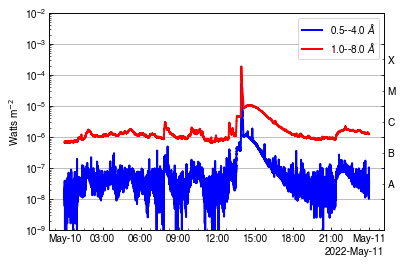

In [18]:
goes_ts.plot()

In [31]:
def read_lya(file):
    data_lya = h5netcdf.File(file, mode="r",
                         decode_vlen_strings=True)


    lya_time = parse_time(parse_time('2000-01-01 12:00:00').utime + data_lya["time"], format="utime").datetime
    lya_ts = pd.Series(data_lya["avgIrradiance1216"][:], index=lya_time)
    lya_ts = lya_ts.replace(-999.0, np.nan)
    return lya_ts

In [34]:
lya_ts = read_lya("sci_exis-l1b-sfeu_g16_d20220510_v1-0-0.nc")

<AxesSubplot:>

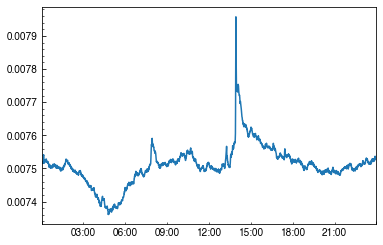

In [35]:
lya_ts.plot()

In [37]:
def read_vlf_data(file):
    """
    Read VLF csv files and return a pandas Series
    """
    aa = pd.read_csv(file, comment="#", names=["date", "data"])
    sid = pd.Series(20*np.log10(aa["data"].values), index=pd.to_datetime(aa["date"]))
    return sid

In [38]:
vlf_ts = read_vlf_data("Dunsink_HWU1_2022-05-10_000000.csv")

In [39]:
def read_magno(file):
    data = pd.read_csv(file, comment=";", 
                       names=["date", "time", "index", "bx", "by", "bz"], 
                       delim_whitespace=True)
    data["datetime"] = pd.to_datetime(data["date"] + data["time"], 
                                      format="%d/%m/%Y%H:%M:%S")
    data.drop(columns=["date", "time", "index"], inplace=True)
    data.set_index("datetime", inplace=True)
    return data

In [40]:
magno_ts = read_magno("dun20220510.txt")

<AxesSubplot:xlabel='date'>

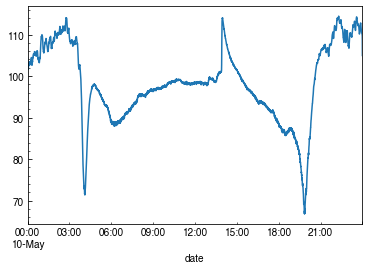

In [41]:
vlf_ts.plot()

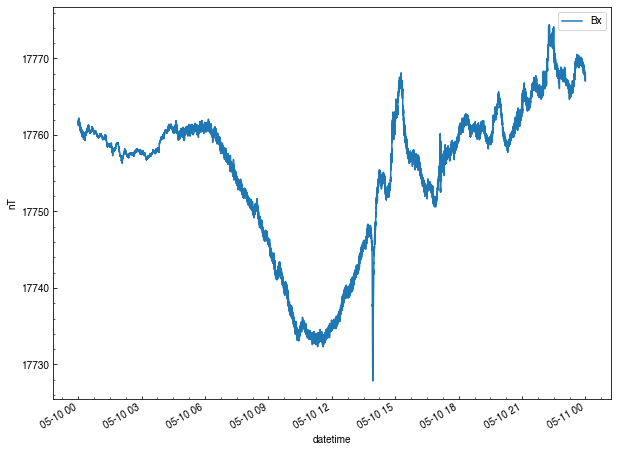

In [53]:
fig, ax = plt.subplots(figsize=(10, 8))
magno_ts["bx"].plot(label="Bx")
plt.ylabel("nT")
plt.legend()
plt.savefig("bx_20220510.png")
# plt.axvline("2022-05-10 14:00")
# plt.axvline("2022-05-10 15:00")

In [59]:
gl = goes_ts.to_dataframe()["xrsb"].truncate("2022-05-10 13:20", "2022-05-10 15:30")

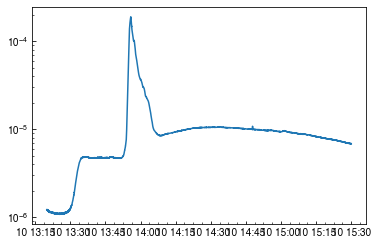

In [60]:
plt.plot(gl)
plt.yscale("log")